<a href="https://colab.research.google.com/github/AnujRameshRindhe/ML/blob/main/ML_Case_Study_Predictive_maintenance_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Predictive maintenance using machine learning techniques***

# **1. Problem Statement**

This case study is focused in the field of Data Science with application to the area of predictive maintenance. Identifying the condition of specific machine & predicting the failure/ maintainenace time for the machines is essential part of industry 4.0.
The cost associated with repair or replacement of faulty machine is much higher. Therefore, the installation of sensors monitors the state of the machine and tracks the deviation of the perfomance of the machine. Early abnormal detection can lead to great savings for industries.


 We consider one main task that focus on  establishing whether a generic machine is about to suffer a failure.

# **2. Data collection**

Predictive Maintenance Dataset is extracted from the UCI Repository to carry out this assignment. In the first place the dataset is explored to obtain a deeper knowledge that can guide in fully understanding the ground truth.

Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, the data provided by the UCI repository is a synthetic dataset that reflects real predictive maintenance encountered in industry. The dataset consists of 10,000 data points stored as rows with 14 features in columns:

**The following feature information is derived from the machine learning repository itself.**

1.   UID: unique identifier ranging from 1 to 10000;

2.   Product ID: consisting of a letter L, M, or H for low (60% of all products), medium (30%) and high (10%) as product quality variants and a variant-specific serial number;

3.  Air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K;

4. Process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K;

5. Rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise;

6. Torque [Nm]: torque values are normally distributed around 40 Nm with a standard deviation of 10 Nm and no negative values;

7. Tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process;

**Machine failure:** label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true. The machine failure consists of five independent failure modes:

8. tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins;

9. heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm;

10. power failure (PWF):the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails;

11. overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain;

12. random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. If at least one of the above failure modes is true, the process fails and the ’machine failure’ label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.

# **3. Data preprocessing**

Some preprocessing techniques are applied to prepare the data for the algorithms we will use to make our predictions.

In [ ]:
# Importing all the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from scipy import stats as st
from scipy.stats import binom
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import time


In [ ]:
# Importing data

data = pd.read_csv("/content/Pred_main_M.csv")
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,600.0,308.6,1551.0,42.8,0.0,0,No Failure
1,2,L47181,NaN,559.0,308.7,1408.0,46.3,3.0,0,No Failure
2,3,L47182,NaN,603.0,308.5,1498.0,49.4,5.0,0,No Failure
3,4,L47183,NaN,NaN,308.6,1433.0,NaN,7.0,0,No Failure
4,5,L47184,NaN,298.2,308.7,8145.0,NaN,9.0,0,No Failure


In [ ]:
# Setting numeric columns- dtype to float
data['Tool wear [min]'] = data['Tool wear [min]'].astype('float64')
data['Rotational speed [rpm]'] = data['Rotational speed [rpm]'].astype('float64')

# Renaming the features
data.rename(mapper={'Air temperature [K]': 'Air temperature',
                    'Process temperature [K]': 'Process temperature',
                    'Rotational speed [rpm]': 'Rotational speed',
                    'Torque [Nm]': 'Torque',
                    'Tool wear [min]': 'Tool wear'}, axis=1, inplace=True)

In [ ]:
data['Product ID'].shape

(10000,)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UDI                  10000 non-null  int64  
 1   Product ID           10000 non-null  object 
 2   Type                 9974 non-null   object 
 3   Air temperature      9748 non-null   float64
 4   Process temperature  9781 non-null   float64
 5   Rotational speed     9995 non-null   float64
 6   Torque               9984 non-null   float64
 7   Tool wear            9993 non-null   float64
 8   Target               10000 non-null  int64  
 9   Failure Type         10000 non-null  object 
dtypes: float64(5), int64(2), object(3)
memory usage: 781.4+ KB


In [ ]:
# Checking the null values in the features

data.isnull().sum()

UDI                      0
Product ID               0
Type                    26
Air temperature        252
Process temperature    219
Rotational speed         5
Torque                  16
Tool wear                7
Target                   0
Failure Type             0
dtype: int64

As we can see, missing values are identified in columns- Type, Air temp, process temp, Rotational speed,Torque & tool wear. We will use imputation techniques according to the characteristics of the features.Let's create a copy before imputing/ changing any data and we will drop the UDI & product ID columns as they are unique for each row & it is not adding any value to our analysis.

In [ ]:
# Creating a copy
df = data.copy()
df.drop(columns=['UDI','Product ID'], inplace=True)


# Checking the distribution before using the mean imputation

<ipython-input-68-6529bbf93983>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Air temperature'], fit=st.norm)


((array([-3.81060943, -3.58545756, -3.46184782, ...,  3.46184782,
          3.58545756,  3.81060943]),
  array([295.3, 295.3, 295.3, ...,   nan,   nan,   nan])),
 (nan, nan, nan))

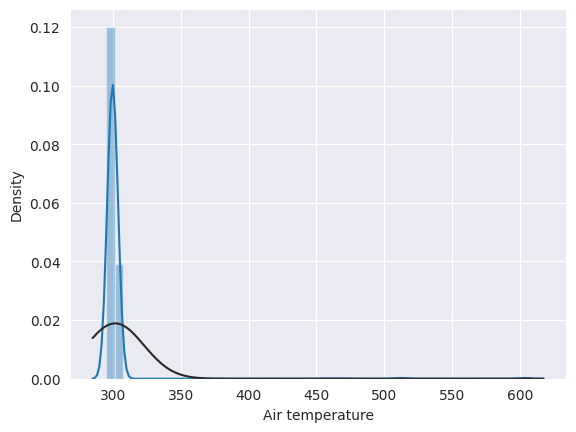

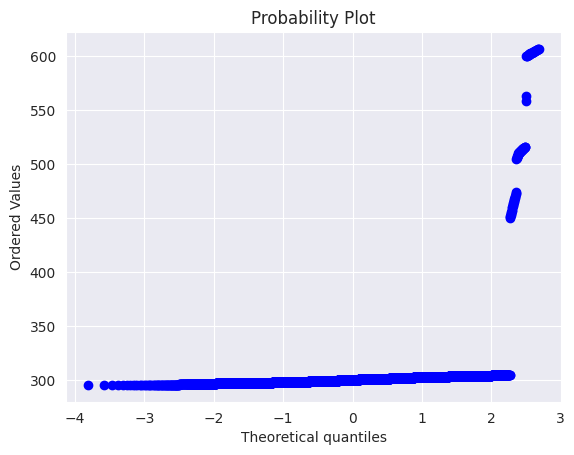

In [ ]:
# Distribution of air temperature
sns.set_style("darkgrid")
sns.distplot(df['Air temperature'], fit=st.norm)
fig = plt.figure()
st.probplot(df['Air temperature'], plot=plt)

<ipython-input-69-9d2ad1154e6a>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Torque'], fit=st.norm)


((array([-3.81060943, -3.58545756, -3.46184782, ...,  3.46184782,
          3.58545756,  3.81060943]),
  array([3.8, 4.2, 4.6, ..., nan, nan, nan])),
 (nan, nan, nan))

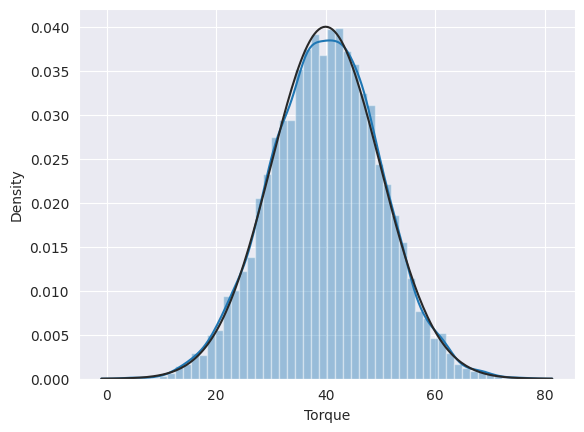

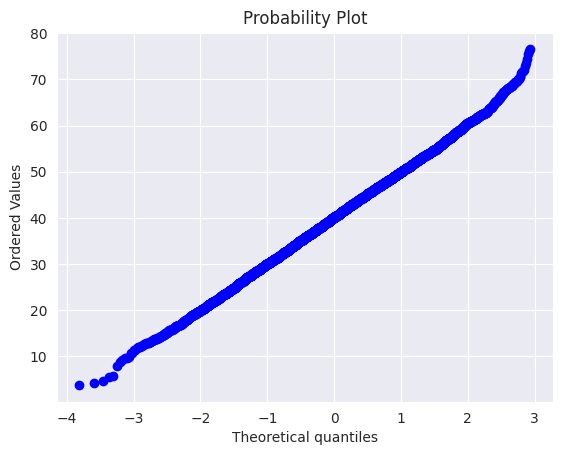

In [ ]:
# Distribution of Torque
sns.set_style("darkgrid")
sns.distplot(df['Torque'], fit=st.norm)
fig = plt.figure()
st.probplot(df['Torque'], plot=plt)

<ipython-input-70-ae64c12f6a3a>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Process temperature'], fit=st.norm)


((array([-3.81060943, -3.58545756, -3.46184782, ...,  3.46184782,
          3.58545756,  3.81060943]),
  array([305.7, 305.7, 305.8, ...,   nan,   nan,   nan])),
 (nan, nan, nan))

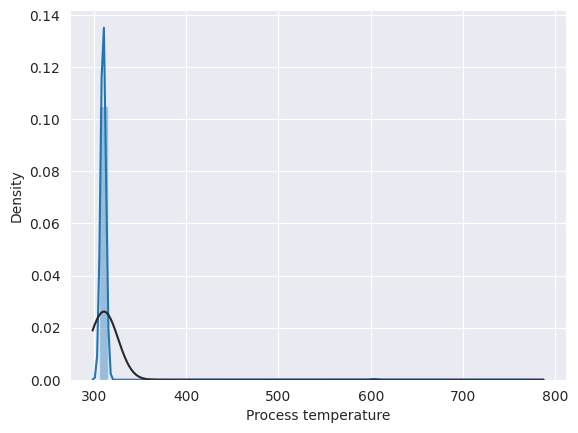

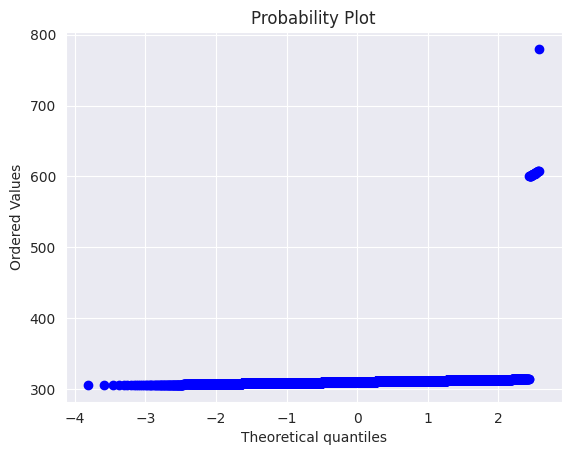

In [ ]:
# Distribution of Process temperature
sns.set_style("darkgrid")
sns.distplot(df['Process temperature'], fit=st.norm)
fig = plt.figure()
st.probplot(df['Process temperature'], plot=plt)

<ipython-input-71-3ecb7b09356f>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Rotational speed'], fit=st.norm)


((array([-3.81060943, -3.58545756, -3.46184782, ...,  3.46184782,
          3.58545756,  3.81060943]),
  array([1168., 1181., 1183., ...,   nan,   nan,   nan])),
 (nan, nan, nan))

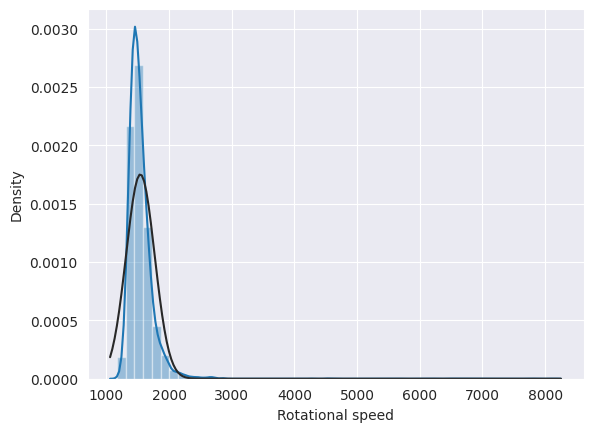

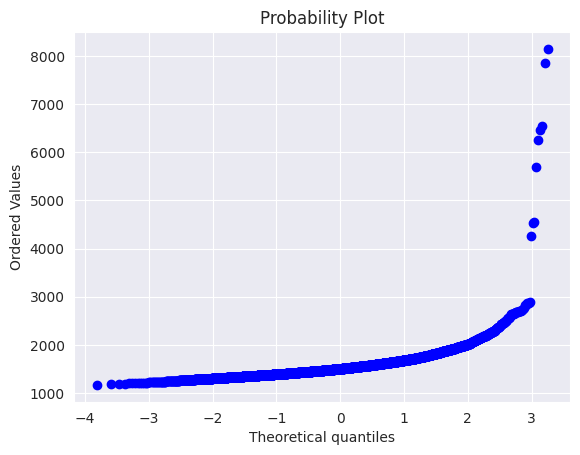

In [ ]:
# Distribution of Rotational speed
sns.set_style("darkgrid")
sns.distplot(df['Rotational speed'], fit=st.norm)
fig = plt.figure()
st.probplot(df['Rotational speed'], plot=plt)

<ipython-input-27-8b0c2f0dd6a4>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Tool wear'], fit=st.norm)


((array([-3.81060943, -3.58545756, -3.46184782, ...,  3.46184782,
          3.58545756,  3.81060943]),
  array([ 0.,  0.,  0., ..., nan, nan, nan])),
 (nan, nan, nan))

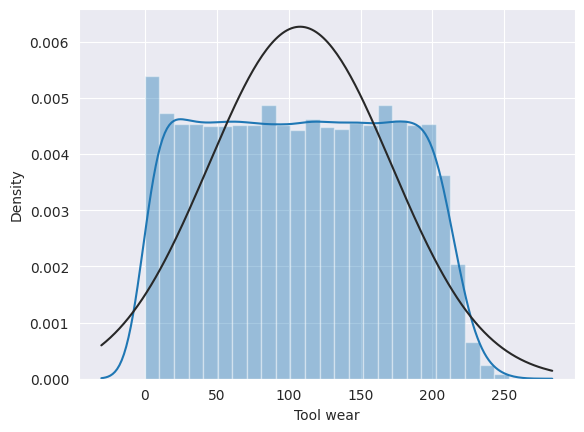

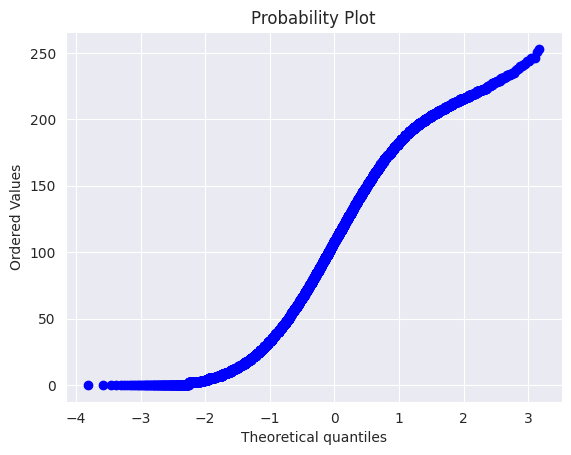

In [ ]:
# Distribution of Rotational speed
sns.set_style("darkgrid")
sns.distplot(df['Tool wear'], fit=st.norm)
fig = plt.figure()
st.probplot(df['Tool wear'], plot=plt)

# **As we can see from the above graphs, some of the distirbutions are skewed due to the outliers, we will use the mean, median and mode imputation for handling missing values, after outlier treatment**

# **Outlier treatment**

In [ ]:
df.describe()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target
count,9748.000000,9781.000000,9995.000000,9984.000000,9993.000000,10000.000000
mean,301.733084,310.811982,1542.713557,39.987149,107.950465,0.033900
std,20.535592,15.345520,227.661681,9.976790,63.676309,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.400000,308.900000,1423.000000,33.200000,53.000000,0.000000
50%,300.200000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.600000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,607.000000,780.000000,8145.000000,76.600000,253.000000,1.000000


**We can guess the presence of outliers in Air temperature, Process temperature, Rotational Speed & Torque because the maximum is very different from the third quartile. To make this consideration more concrete we take a closer look at the situation with boxplots, using histograms to understand the distribution.**

In [ ]:
features = [col for col in df.columns
            if df[col].dtype=='float64' or col =='Type']
target = ['Target','Failure Type']

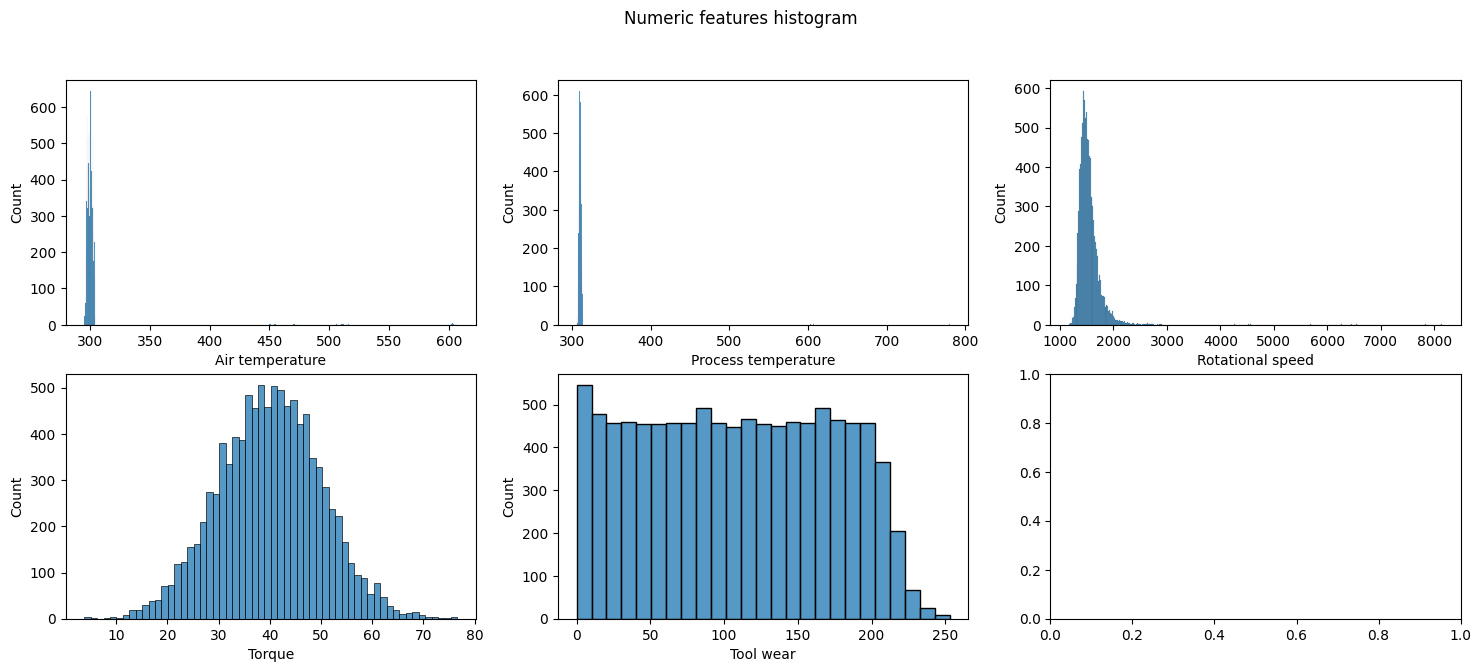

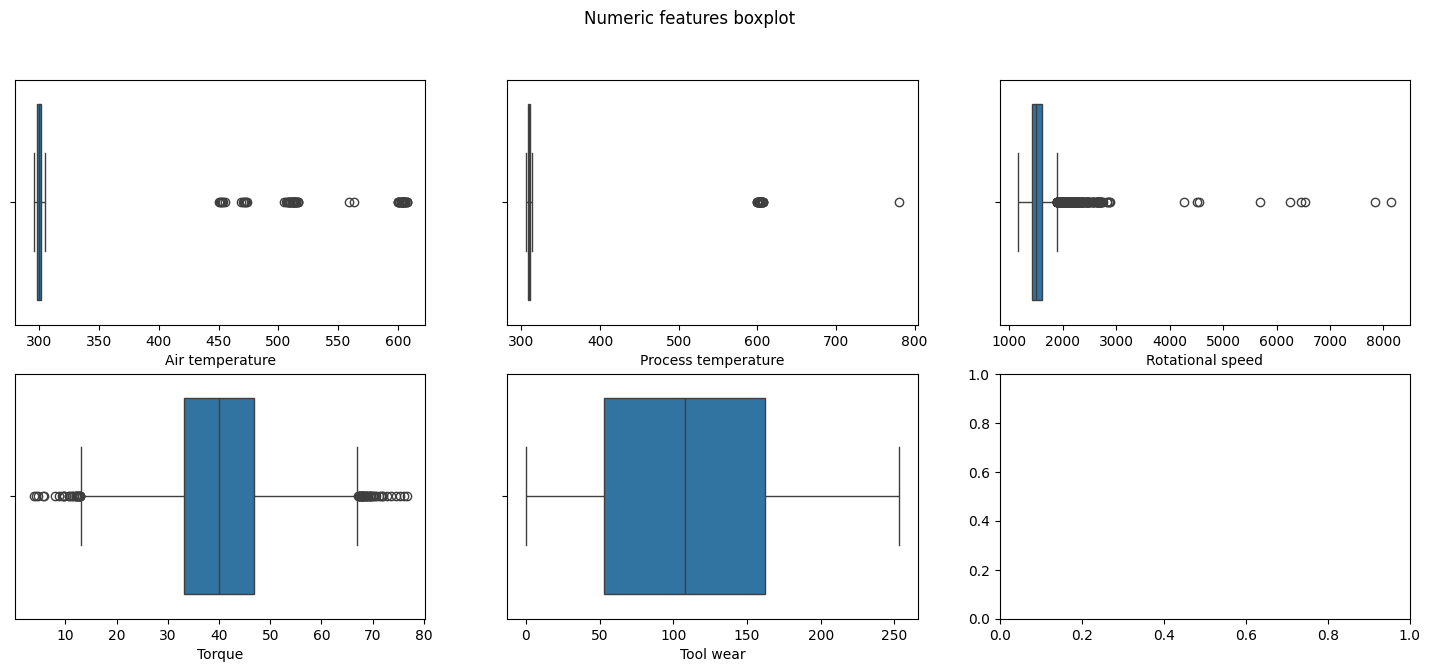

In [ ]:
num_features = [feature for feature in features if df[feature].dtype=='float64']
# Histograms of numeric features
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features histogram')
for j, feature in enumerate(num_features):
    sns.histplot(ax=axs[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()

# boxplot of numeric features
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features boxplot')
for j, feature in enumerate(num_features):
    sns.boxplot(ax=axs[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()


# **Important observations for outliers-**

**1. The boxplots highlight possible outliers in the features, as we can observe the data of air temp and process temp is highly skewed. There are some outliers, but it is possible that temperature might have increased and caused heat dissipation failure (one of the failure type in dataset), hence we can't neglect the possibility of failures.It will be practical to keep the outliers as of now.**

**2. In rotational speed, we can observe few values above 4000 rpm which seems to be the outliers. It is not unrealistic to think that the few observation with high Rotational Speed are going to fail. As a result we keep the outliers for now and we reserve the right to decide whether to act on them or not after considering other aspects.**

**3. The torque and tool wear data seems to be normally distributed, these features are not affected by the outliers hence we can use mean imputation for replacing the missing values.**


# **Removal of unecessary data**

Before proceeding further, we deal with the two ID columns as the model we will use could get confused by them, since it is unrealistic to think that the failure of a machine depends on its identifier. Product ID column does not actually carry any more information than the feature Type and it is legit to drop it.

In [ ]:
df.head()

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Failure Type
0,M,298.1,308.6,1551.0,42.8,0.0,0,No Failure
1,L,298.2,308.7,1408.0,46.3,3.0,0,No Failure
2,L,298.1,308.5,1498.0,49.4,5.0,0,No Failure
3,L,298.2,308.6,1433.0,39.5,7.0,0,No Failure
4,L,298.2,308.7,1408.0,40.0,9.0,0,No Failure


The data where failure is random means the failure is random and can't be predicted. Hence, it is better if we remove these rows. The number of observations are around 18, there is not much data loss.

In [ ]:
# Create lists of features and target names
features = [col for col in df.columns
            if df[col].dtype=='float64' or col =='Type']
target = ['Target','Failure Type']
# Portion of data where RNF=1
idx_RNF = df.loc[df['Failure Type']=='Random Failures'].index
df.loc[idx_RNF,target]

,Target,Failure Type
1221,0,Random Failures
1302,0,Random Failures
1748,0,Random Failures
2072,0,Random Failures
2559,0,Random Failures
3065,0,Random Failures
3452,0,Random Failures
5471,0,Random Failures
5489,0,Random Failures
5495,0,Random Failures


In [ ]:
first_drop = df.loc[idx_RNF,target].shape[0]
print('Number of observations where RNF=1 but Machine failure=0:',first_drop)
# Drop corresponding observations and RNF column
df.drop(index=idx_RNF, inplace=True)

Number of observations where RNF=1 but Machine failure=0: 18


Also, we find out that in 9 observations Machine failure is set to 1 when all types of failures are set to 0. We cannot understand if there really was a failure or not so let’s remove these observations too.

In [ ]:
# Portion of data where Machine failure=1 but no failure cause is specified
idx_ambiguous = df.loc[(df['Target']==1) &
                       (df['Failure Type']=='No Failure')].index
second_drop = df.loc[idx_ambiguous].shape[0]
print('Number of ambiguous observations:', second_drop)
display(df.loc[idx_ambiguous,target])
df.drop(index=idx_ambiguous, inplace=True)

Number of ambiguous observations: 9


,Target,Failure Type
1437,1,No Failure
2749,1,No Failure
4044,1,No Failure
4684,1,No Failure
5536,1,No Failure
5941,1,No Failure
6478,1,No Failure
8506,1,No Failure
9015,1,No Failure


#**Percentage of removed observations**

In [ ]:
n = df.shape[0]
print('Percentage of removed values:',
     (100*(first_drop+second_drop)/n))
df.reset_index(drop=True, inplace=True)   # Reset index


Percentage of removed values: 0.2707309736287978


Our alteration has not affected the data very much.

# **Hanling missing values after removal of uneccessary data & outlier analysis**

## **Using median imputation for handling missing values as process temp, air temp & rotational speed has outliers which can't be removed for analysis purpose.**

In [ ]:
# Using mean imputation for process temperature, air temp,rotational speed, torque & tool wear


# # Filling the missing value in the Air temperature by mean
df['Air temperature'] = df['Air temperature'].fillna(df['Air temperature'].median())

# # Filling the missing value in the Process temperature by mean
df['Process temperature'] = df['Process temperature'].fillna(df['Process temperature'].median())

# # Filling the missing value in the Rotational speed by mean
df['Rotational speed'] = df['Rotational speed'].fillna(df['Rotational speed'].median())


## **Using mean imputation for Torque & Tool wear as these features are not affected by outliers as seen in box plots.**

In [ ]:
# # Filling the missing value in the Torque by mean
df['Torque'] = df['Torque'].fillna(df['Torque'].mean())

# # Filling the missing value in the Tool wear by mean
df['Tool wear'] = df['Torque'].fillna(df['Tool wear'].mean())

In [ ]:
# Before that lets check the value counts

Type=df['Type'].value_counts()
print("The count of different types are",Type)

Mode=df['Type'].mode()
print("The common type is",Mode)

The count of different types are L    5959
M    2990
H     998
Name: Type, dtype: int64
The common type is 0    L
Name: Type, dtype: object


## **Usind mode imputation for categorical feature- Type**

In [ ]:
# using mode imputation for type feature as there are specific categories (L,M,H)
df['Type'] = df['Type'].fillna(value=df['Type'].mode()[0])

In [ ]:
# Checking the null values

df.isna().any()

Type                   False
Air temperature        False
Process temperature    False
Rotational speed       False
Torque                 False
Tool wear              False
Target                 False
Failure Type           False
dtype: bool

# **Resampling with SMOTE**

Another observation of extremely low occurrence of machine failures among the entire dataset, which percentage is equal only to 3.31%. Moreover, a pie plot showing the occurrence of the causes involved for each failure reveals a further degree of imbalance.

Failures percentage in data: 3.31


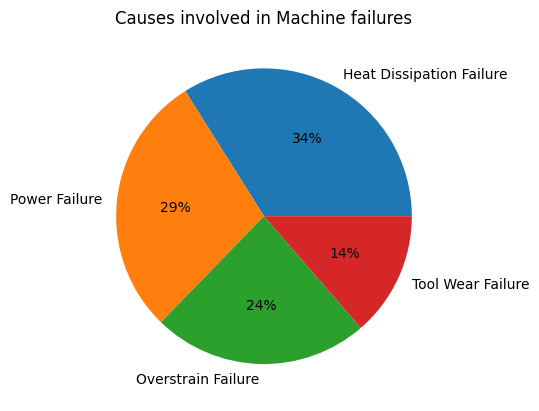

In [ ]:
# Portion of df where there is a failure and causes percentage
idx_fail = df.loc[df['Failure Type'] != 'No Failure'].index
df_fail = df.loc[idx_fail]
df_fail_percentage = 100*df_fail['Failure Type'].value_counts()/df_fail['Failure Type'].shape[0]
print('Failures percentage in data:',
      round(100*df['Target'].sum()/n,2))
# Pie plot
plt.title('Causes involved in Machine failures')
plt.pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
plt.show()

In [ ]:
df_fail['Failure Type'].value_counts()

Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
Name: Failure Type, dtype: int64

###**1. This dataset has classes imbalance problem, it can mislead both the models training process and our ability to interpret the results. For example, if we build a model on this dataset that predicts that machines never fail, it should be 97% accurate. In order to avoid such problems and limit the bias behaviour of the models with respect to individual classes we perform resampling of data.**

###**2. We will use the SMOTE procedure to generate new samples, which is very much like slightly moving the data point in the direction of its neighbors. This way, the synthetic data point is not an exact copy of an existing data point but we can also be sure that it is also not too different from the known observations in the minority class.**



In [ ]:
# n_working must represent 80% of the desired length of resampled dataframe
n_working = df['Failure Type'].value_counts()['No Failure']
desired_length = round(n_working/0.8)
spc = round((desired_length-n_working)/4)  #samples per class
# Resampling
balance_cause = {'No Failure':n_working,
                 'Overstrain Failure':spc,
                 'Heat Dissipation Failure':spc,
                 'Power Failure':spc,
                 'Tool Wear Failure':spc}
sm = SMOTENC(categorical_features=[0,7], sampling_strategy=balance_cause, random_state=0)
df_res, y_res = sm.fit_resample(df, df['Failure Type'])

# **Comparison after sampling**

Percentage increment of observations after oversampling: 20.88
SMOTE Resampled Failures percentage: 20.01


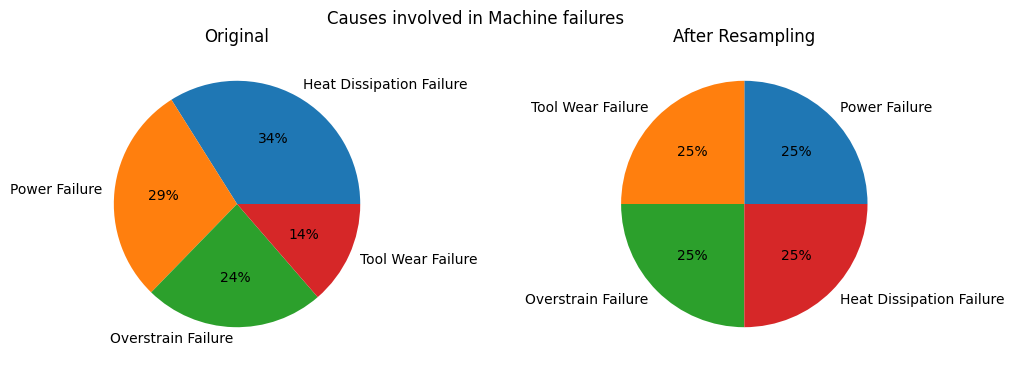

In [ ]:
# Portion of df_res where there is a failure and causes percentage
idx_fail_res = df_res.loc[df_res['Failure Type'] != 'No Failure'].index
df_res_fail = df_res.loc[idx_fail_res]
fail_res_percentage = 100*df_res_fail['Failure Type'].value_counts()/df_res_fail.shape[0]

# Percentages
print('Percentage increment of observations after oversampling:',
      round((df_res.shape[0]-df.shape[0])*100/df.shape[0],2))
print('SMOTE Resampled Failures percentage:',
      round(df_res_fail.shape[0]*100/df_res.shape[0],2))

# Pie plot
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
fig.suptitle('Causes involved in Machine failures')
axs[0].pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[1].pie(x=fail_res_percentage.array, labels=fail_res_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[0].title.set_text('Original')
axs[1].title.set_text('After Resampling')
plt.show()

1. The cases of Machine Failure mainly concern low quality machines, then those of medium quality and only a few times those of high quality. This difference is accentuated when the number of observations of non-functioning machines is (artificially) increased.

2. The majority of failures concern type L machines is due to the greater presence of this type in the dataset and therefore that the correlation with the failure of the machine is due to statistical reasons.

# **Feature scaling & encoding**

In order to make data exploitable for the algorithms we will run, we apply two transformations:

1. First, we apply a label encoding to the categorical columns, since Type is an ordinal feature and Cause must be represented in one column. The mapping follows this scheme: Type: {L=0, M=1, H=2} Cause: {Working=0, PWF=1, OSF=2, HDF=3, TWF=4}
2. Secondly we perform the scaling of the columns with StandardScaler. This is particularly useful for the good working of methods that rely on the metric space, such as PCA and KNN.

In [ ]:
sc = StandardScaler()
type_dict = {'L': 0, 'M': 1, 'H': 2}
cause_dict = {'No Failure': 0,
              'Power Failure': 1,
              'Overstrain Failure': 2,
              'Heat Dissipation Failure': 3,
              'Tool Wear Failure': 4}
df_pre = df_res.copy()
# Encoding
df_pre['Type'].replace(to_replace=type_dict, inplace=True)
df_pre['Failure Type'].replace(to_replace=cause_dict, inplace=True)
# Scaling
df_pre[num_features] = sc.fit_transform(df_pre[num_features])

# **4. Exploratory Data Analysis (EDA)**

Our data exploration starts by checking that each entry is unique and there are no duplicates; this is done by veryfing that the number of unique ProductID corresponds to the number of observations. Then we print a report to look for missing values and check the data type for each column.

In [ ]:
data.describe()

,UDI,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target
count,10000.00000,9978.000000,9975.000000,9995.000000,9994.000000,9993.000000,10000.000000
mean,5000.50000,300.065865,310.056000,1540.604902,39.987272,107.950465,0.033900
std,2886.89568,4.486940,4.934225,203.809106,9.971903,63.676309,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,603.000000,780.000000,8145.000000,76.600000,253.000000,1.000000


# **Observations-**
1. We have already analysed and replaced the outliers from the features like, Air temp, Process temp & Rotational speed

# **Percentages of machines by Type:**

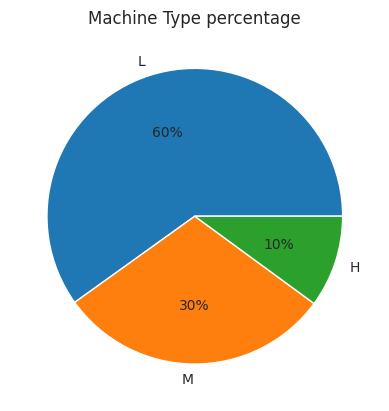

In [ ]:
# Pie chart of Type percentage
value = data['Type'].value_counts()
Type_percentage = 100*value/data.Type.shape[0]
labels = Type_percentage.index.array
x = Type_percentage.array
plt.pie(x, labels = labels, colors=sns.color_palette('tab10')[0:3], autopct='%.0f%%')
plt.title('Machine Type percentage')
plt.show()

# **Relation between tool wear failure & rotational speed**

<Axes: xlabel='Tool wear', ylabel='Rotational speed'>

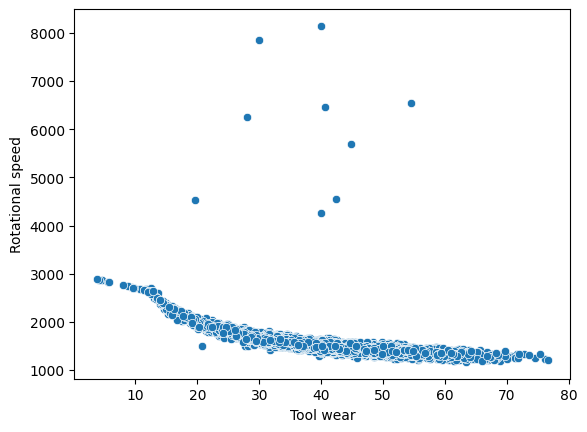

In [ ]:
sns.scatterplot(data=df, x="Tool wear", y="Rotational speed")

# **Distirbution of Failure types (without resampling)**

<Axes: xlabel='Failure Type', ylabel='Percent'>

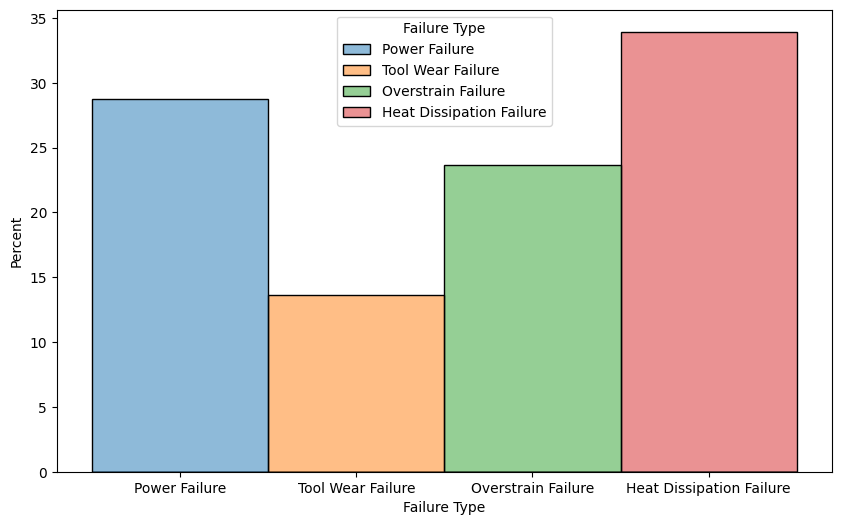

In [ ]:
df_no_fail = df.loc[df["Failure Type"] != 'No Failure']

plt.figure(figsize=(10,6))
sns.histplot(data=df_no_fail, x="Failure Type",stat='percent',hue="Failure Type")

**Observation-**
1. Failure due to heat dissipation is more, followed by power failure, overstrain failure & then tool wear failure. This data is before SMOTE resampling.

# **In which type we observe the maximum failure?**

<Axes: xlabel='Failure Type', ylabel='Type'>

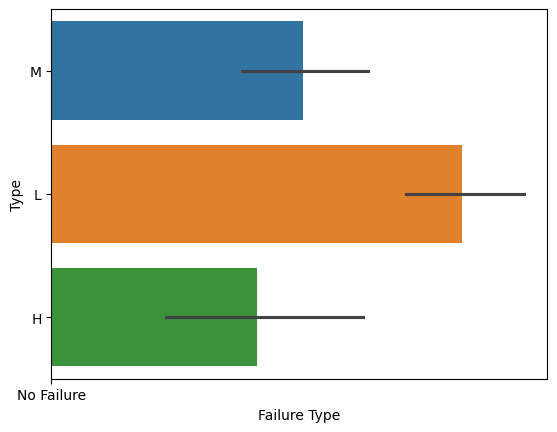

In [ ]:
sns.barplot(df, x="Failure Type", y="Type",hue="Type",orient="y")

# **PCA**

In [ ]:
pca = PCA(n_components=len(num_features))
X_pca = pd.DataFrame(data=pca.fit_transform(df_pre[num_features]), columns=['PC'+str(i+1) for i in range(len(num_features))])
var_exp = pd.Series(data=100*pca.explained_variance_ratio_, index=['PC'+str(i+1) for i in range(len(num_features))])
print('Explained variance ratio per component:', round(var_exp,2), sep='\n')
print('Explained variance ratio with 3 components: '+str(round(var_exp.values[:3].sum(),2)))

Explained variance ratio per component:
PC1    53.15
PC2    20.56
PC3    19.48
PC4     6.81
PC5     0.00
dtype: float64
Explained variance ratio with 3 components: 93.19


# **Since the first three components are enough to almost fully represent the variance of the data we will project them in a three dimensional space.**

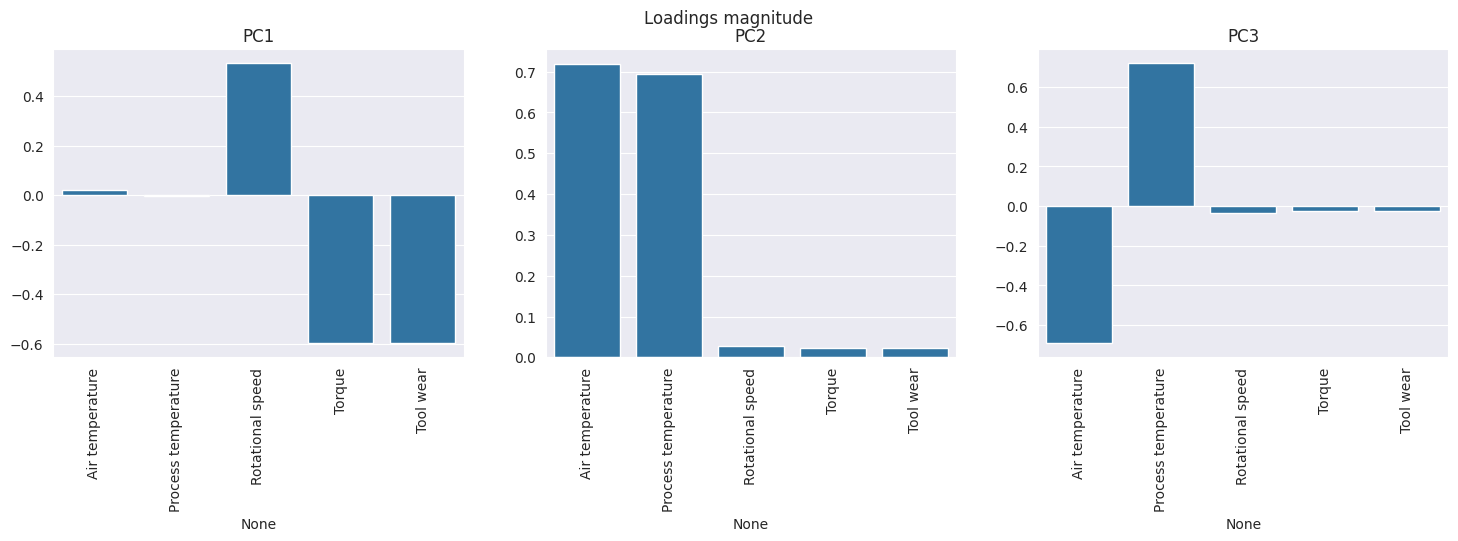

In [ ]:
# PCA for Data visualization
pca3 = PCA(n_components=3)
X_pca3 = pd.DataFrame(data=pca3.fit_transform(df_pre[num_features]), columns=['PC1','PC2','PC3'])

# Loadings Analysis
fig, axs = plt.subplots(ncols=3, figsize=(18,4))
fig.suptitle('Loadings magnitude')
pca_loadings = pd.DataFrame(data=pca3.components_, columns=num_features)
for j in range(3):
    ax = axs[j]
    sns.barplot(ax=ax, x=pca_loadings.columns, y=pca_loadings.values[j])
    ax.tick_params(axis='x', rotation=90)
    ax.title.set_text('PC'+str(j+1))
plt.show()

# The bar plot of Principal Components weights makes easy to understand what they represent:

# 1. PC1 is closely related to the torque & tool wear;
# 2. PC2 can be identified with the temperature part.
# 3. PC3 is identifiable with Tool rotational speed, torque & tool wear

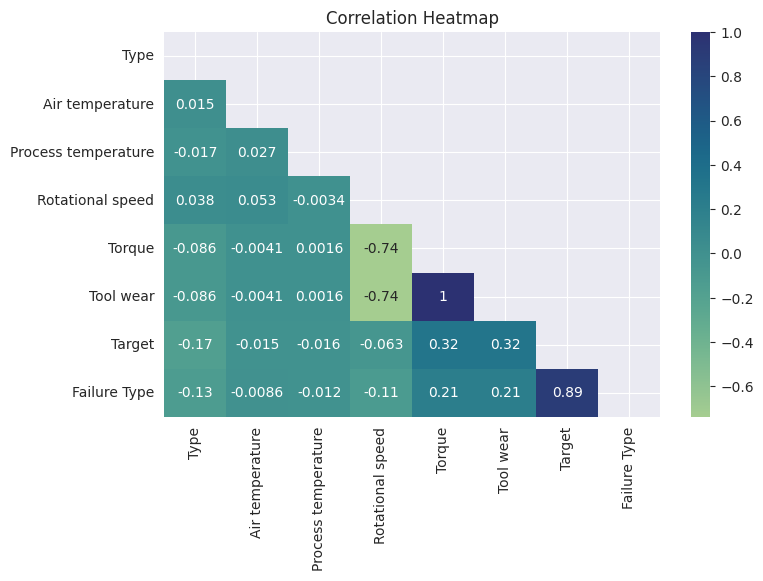

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(8,5))
sns.heatmap(data=df_pre.corr(), mask=np.triu(df_pre.corr()), annot=True, cmap='crest')
plt.title('Correlation Heatmap')
plt.show()

# **Observations-**
1. We observe that the features related to temperature, as well as those related to power, are widely correlated.
2. Tool Wear correlates well with both of our targets, confirming what we have observed by studying PCA.

# **5. Model Selection, Training & Evaluation**

1. Now, we have to find the best model for binary classification of the dataset to predict whether or not there will be Machine Failure.

2. The starting dataset is usually divided into three groups: the training dataset,the validation dataset, i.e. the sample of data used to provide an evaluation of a model fit on the training dataset while tuning model hyperparameters and the test dataset, which has the purpose of testing the model.

3. We will use the ratio (80/10/10) for the split because we test the model for all of these strategies and find that it is the best one. The classification techniques we choose to implement are the following:

*   Logistic Regression: We decide to use Logistic Regression as a Benchmark model, a basic model that represents the starting point for comparing the results obtained from other models.
*   K-nearest neighbors (K-NN)
*   Support Vector Machine
*   Random Forest
*   XGBoost










In [ ]:
# train-validation-test split
X, y = df_pre[features], df_pre[['Target','Failure Type']]
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, stratify=df_pre['Failure Type'], random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.11, stratify=y_trainval['Failure Type'], random_state=0)

In [ ]:
"""User-defined function: Evaluate cm, accurcay, AUC, F1 for a given classifier
- model, fitted estimator.
- X, data used to estimate class probabilities (paired with y_true)
- y_true, ground truth with two columns
- y_pred, predictions
- task = 'binary','multi_class'
"""
def eval_preds(model,X,y_true,y_pred,task):
    if task == 'binary':
        # Extract task target
        y_true = y_true['Target']
        cm = confusion_matrix(y_true, y_pred)
        # Probability of the minority class
        proba = model.predict_proba(X)[:,1]
        # Metrics
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, proba)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        f2 = fbeta_score(y_true, y_pred, pos_label=1, beta=2)
    elif task == 'multi_class':
        y_true = y_true['Failure Type']
        cm = confusion_matrix(y_true, y_pred)
        proba = model.predict_proba(X)
        # Metrics
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, proba, multi_class='ovr', average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        f2 = fbeta_score(y_true, y_pred, beta=2, average='weighted')
    metrics = pd.Series(data={'ACC':acc, 'AUC':auc, 'F1':f1, 'F2':f2})
    metrics = round(metrics,3)
    return cm, metrics



"""User-defined function: Fits one estimator using GridSearch to search for the best parameters
- clf, estimator
- X, y = X_train, y_train
- params, parameters grid for GridSearch
- task = 'binary','multi_class'
"""
def tune_and_fit(clf,X,y,params,task):
    if task=='binary':
        f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)
        start_time = time.time()
        grid_model = GridSearchCV(clf, param_grid=params,
                                cv=5, scoring=f2_scorer)
        grid_model.fit(X, y['Target'])
    elif task=='multi_class':
        f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
        start_time = time.time()
        grid_model = GridSearchCV(clf, param_grid=params,
                              cv=5, scoring=f2_scorer)
        grid_model.fit(X, y['Failure Type'])

    print('Best params:', grid_model.best_params_)
    # Print training times
    train_time = time.time()-start_time
    mins = int(train_time//60)
    print('Training time: '+str(mins)+'m '+str(round(train_time-mins*60))+'s')
    return grid_model



"""User-defined function: Makes predictions using the tuned classifiers.
Then uses eval_preds to compute the relative metrics. Returns:
- y_pred, DataFrame containing the predictions of each model
- cm_list, confusion matrix list
- metrics, DataFrame containing the metrics
Input:
- fitted_models, fitted estimators
- X, data used to make predictions
- y_true, true values for target
- clf_str, list containing estimators names
- task = 'binary','multi_class'
"""
def predict_and_evaluate(fitted_models,X,y_true,clf_str,task):
    cm_dict = {key: np.nan for key in clf_str}
    metrics = pd.DataFrame(columns=clf_str)
    y_pred = pd.DataFrame(columns=clf_str)
    for fit_model, model_name in zip(fitted_models,clf_str):
        # Update predictions
        y_pred[model_name] = fit_model.predict(X)
        # Metrics
        if task == 'binary':
            cm, scores = eval_preds(fit_model,X,y_true,
                                     y_pred[model_name],task)
        elif task == 'multi_class':
            cm, scores = eval_preds(fit_model,X,y_true,
                                     y_pred[model_name],task)
        # Update Confusion matrix and metrics
        cm_dict[model_name] = cm
        metrics[model_name] = scores
    return y_pred, cm_dict, metrics



"""User-defined function: Fit the estimators on multiple classifiers
- clf, estimators
- clf_str, list containing estimators names
- X_train,y_train, data used to fit models
- X_val,y_val, data used to validate models
"""

def fit_models(clf,clf_str,X_train,X_val,y_train,y_val):
    metrics = pd.DataFrame(columns=clf_str)
    for model, model_name in zip(clf, clf_str):
        model.fit(X_train,y_train['Target'])
        y_val_pred = model.predict(X_val)
        metrics[model_name] = eval_preds(model,X_val,y_val,y_val_pred,'binary')[1]
    return metrics

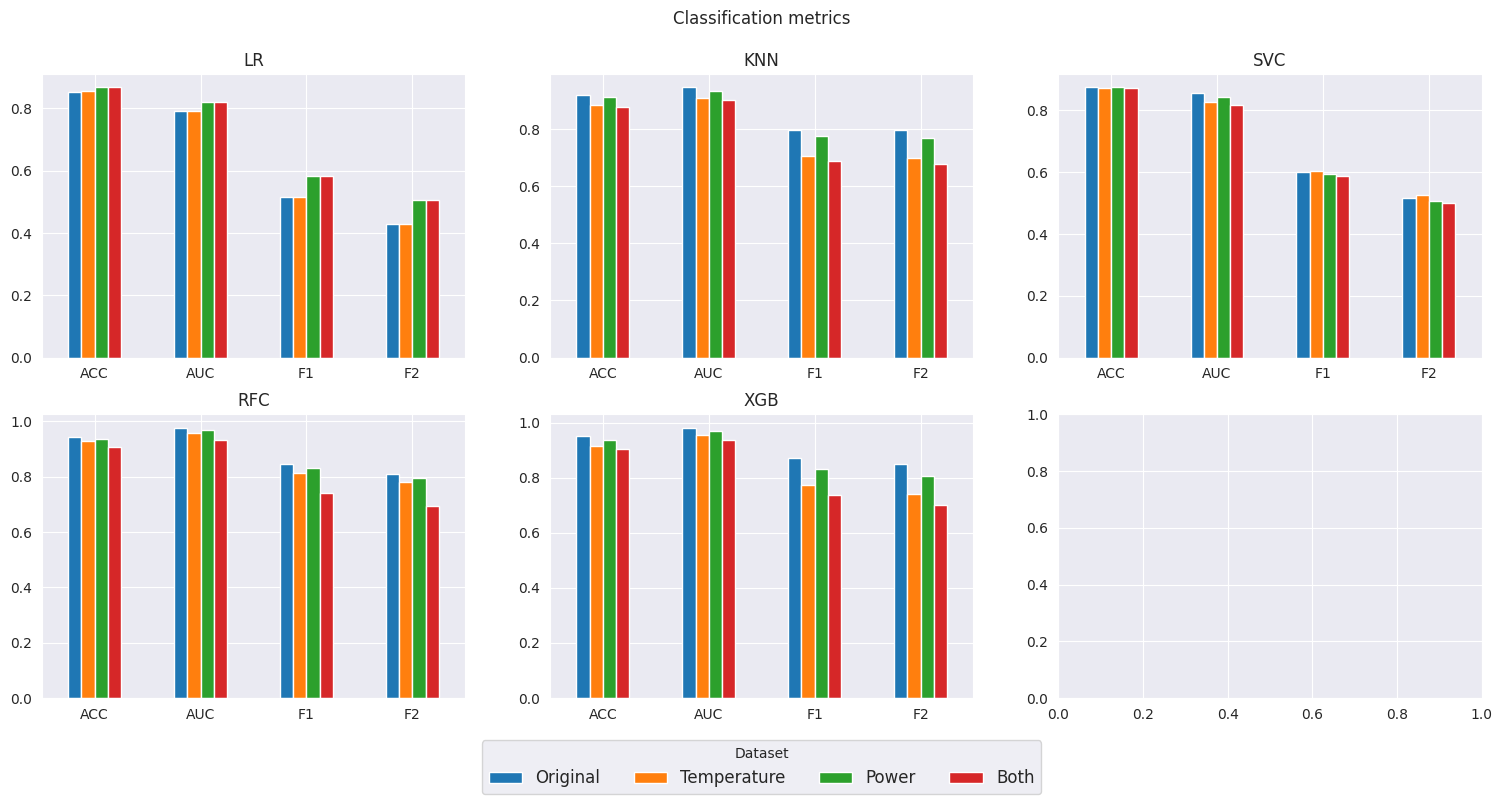

In [ ]:
# Models
lr = LogisticRegression()
knn = KNeighborsClassifier()
svc = SVC(probability=True)
rfc = RandomForestClassifier()
xgb = XGBClassifier()

clf = [lr,knn,svc,rfc,xgb]
clf_str = ['LR','KNN','SVC','RFC','XGB']

# Fit on raw train
metrics_0 = fit_models(clf,clf_str,X_train,X_val,y_train,y_val)

# Fit on temperature product train
XX_train = X_train.drop(columns=['Process temperature','Air temperature'])
XX_val = X_val.drop(columns=['Process temperature','Air temperature'])
XX_train['Temperature']= X_train['Process temperature']*X_train['Air temperature']
XX_val['Temperature'] = X_val['Process temperature']*X_val['Air temperature']
metrics_1 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

# Fit on power product train
XX_train = X_train.drop(columns=['Rotational speed','Torque'])
XX_val = X_val.drop(columns=['Rotational speed','Torque'])
XX_train['Power'] = X_train['Rotational speed']*X_train['Torque']
XX_val['Power'] = X_val['Rotational speed']*X_val['Torque']
metrics_2 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

# Fit on both products train
XX_train = X_train.drop(columns=['Process temperature','Air temperature','Rotational speed','Torque'])
XX_val = X_val.drop(columns=['Process temperature','Air temperature','Rotational speed','Torque'])
XX_train['Temperature']= X_train['Process temperature']*X_train['Air temperature']
XX_val['Temperature']= X_val['Process temperature']*X_val['Air temperature']
XX_train['Power'] = X_train['Rotational speed']*X_train['Torque']
XX_val['Power'] = X_val['Rotational speed']*X_val['Torque']
metrics_3 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

# classification metrics barplot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,8))
fig.suptitle('Classification metrics')
for j, model in enumerate(clf_str):
    ax = axs[j//3,j-3*(j//3)]
    model_metrics = pd.DataFrame(data=[metrics_0[model],metrics_1[model],metrics_2[model],metrics_3[model]])
    model_metrics.index = ['Original','Temperature','Power','Both']
    model_metrics.transpose().plot(ax=ax, kind='bar', rot=0, )
    ax.title.set_text(model)
    ax.get_legend().remove()
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)
axs.flatten()[-2].legend(title='Dataset', loc='upper center',
                         bbox_to_anchor=(0.5, -0.12), ncol=4, fontsize=12)
plt.show()


**Observations-**
1. From the results obtained, we observe that all the models applied to the entire dataset perform better than when they are applied to the ones created by reducing the number of features. The best performances and the modest number of features from which our dataset is composed encourage us to opt to avoid the feature selection step.

# **Logistic Regression as a Benchmark**

Validation set metrics:
ACC    0.865
AUC    0.822
F1     0.584
F2     0.512
dtype: float64
Test set metrics:
ACC    0.867
AUC    0.835
F1     0.582
F2     0.505
dtype: float64


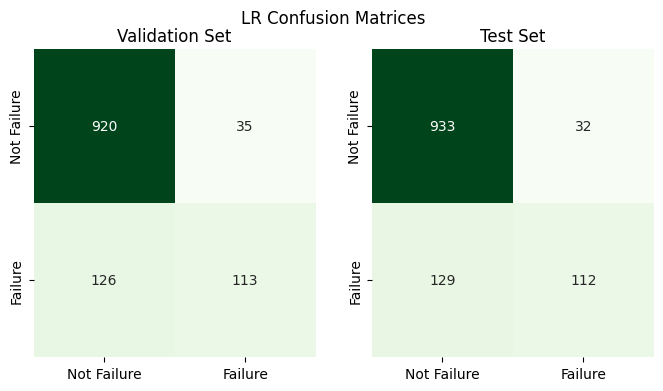

In [ ]:
# Make predictions
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train['Target'])
y_val_lr = lr.predict(X_val)
y_test_lr = lr.predict(X_test)

# Metrics
cm_val_lr, metrics_val_lr = eval_preds(lr,X_val,y_val,y_val_lr,'binary')
cm_test_lr, metrics_test_lr = eval_preds(lr,X_test,y_test,y_test_lr,'binary')
print('Validation set metrics:',metrics_val_lr, sep='\n')
print('Test set metrics:',metrics_test_lr, sep='\n')

cm_labels = ['Not Failure', 'Failure']
cm_lr = [cm_val_lr, cm_test_lr]
# Show Confusion Matrices
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
fig.suptitle('LR Confusion Matrices')
for j, title in enumerate(['Validation Set', 'Test Set']):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_lr[j], annot=True,
              fmt='d', cmap='Greens', cbar=False)
    axs[j].title.set_text(title)
    axs[j].set_xticklabels(cm_labels)
    axs[j].set_yticklabels(cm_labels)
plt.show()


# **Deploying Models**

In [ ]:
# Models
knn = KNeighborsClassifier()
svc = SVC()
rfc = RandomForestClassifier()
xgb = XGBClassifier()
clf = [knn,svc,rfc,xgb]
clf_str = ['KNN','SVC','RFC','XGB']

# Parameter grids for GridSearch
knn_params = {'n_neighbors':[1,3,5,8,10]}
svc_params = {'C': [1, 10, 100],
              'gamma': [0.1,1],
              'kernel': ['rbf'],
              'probability':[True],
              'random_state':[0]}
rfc_params = {'n_estimators':[100,300,500,700],
              'max_depth':[5,7,10],
              'random_state':[0]}
xgb_params = {'n_estimators':[300,500,700],
              'max_depth':[5,7],
              'learning_rate':[0.01,0.1],
              'objective':['binary:logistic']}
params = pd.Series(data=[knn_params,svc_params,rfc_params,xgb_params],
                   index=clf)

# Tune hyperparameters with GridSearch

print('GridSearch start')
fitted_models_binary = []
for model, model_name in zip(clf, clf_str):
    print('Training '+str(model_name))
    fit_model = tune_and_fit(model,X_train,y_train,params[model],'binary')
    fitted_models_binary.append(fit_model)

GridSearch start
Training KNN
Best params: {'n_neighbors': 1}
Training time: 0m 4s
Training SVC
Best params: {'C': 100, 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 0}
Training time: 4m 35s
Training RFC
Best params: {'max_depth': 10, 'n_estimators': 500, 'random_state': 0}
Training time: 3m 33s
Training XGB
Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 700, 'objective': 'binary:logistic'}
Training time: 0m 50s


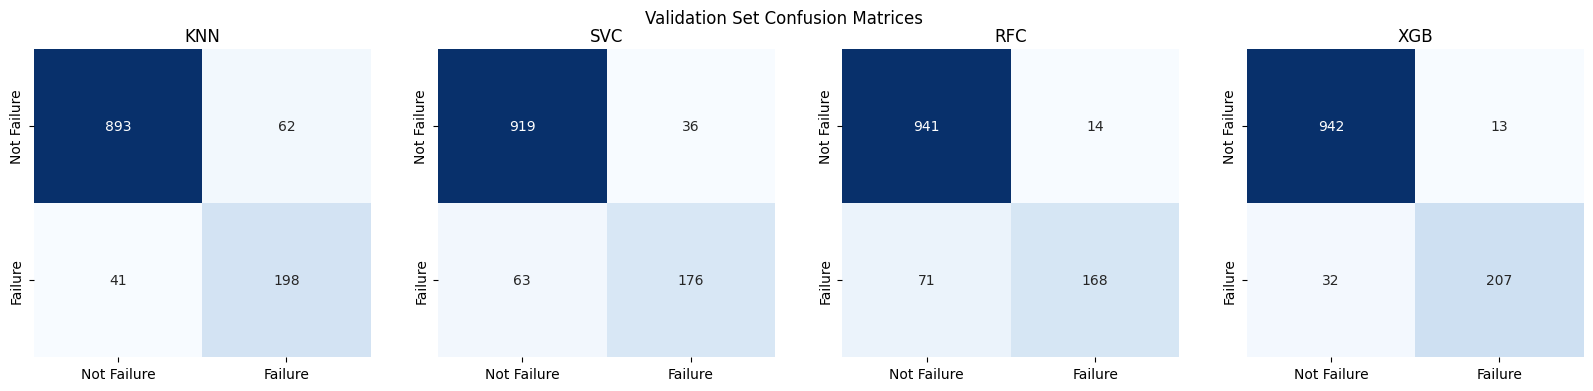

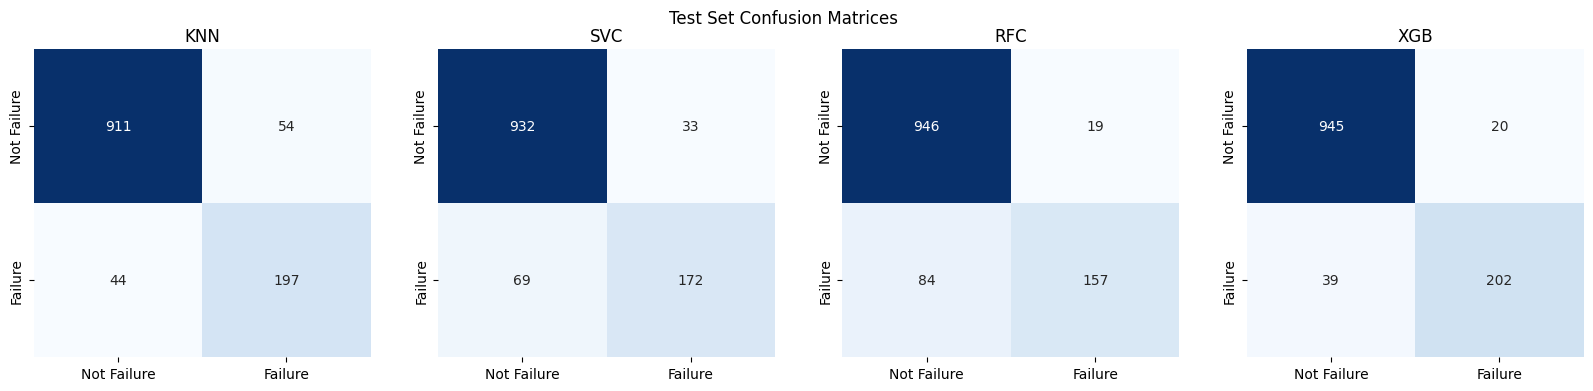


Validation scores:
       KNN    SVC    RFC    XGB
ACC  0.914  0.917  0.929  0.962
AUC  0.882  0.944  0.959  0.984
F1   0.794  0.780  0.798  0.902
F2   0.814  0.753  0.738  0.880
Test scores:
       KNN    SVC    RFC    XGB
ACC  0.919  0.915  0.915  0.951
AUC  0.881  0.951  0.951  0.985
F1   0.801  0.771  0.753  0.873
F2   0.811  0.736  0.689  0.852


In [ ]:
# Create evaluation metrics
task = 'binary'
y_pred_val, cm_dict_val, metrics_val = predict_and_evaluate(
    fitted_models_binary,X_val,y_val,clf_str,task)
y_pred_test, cm_dict_test, metrics_test = predict_and_evaluate(
    fitted_models_binary,X_test,y_test,clf_str,task)

# Show Validation Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Validation Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_val[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Show Test Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Test Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_test[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Print scores
print('')
print('Validation scores:', metrics_val, sep='\n')
print('Test scores:', metrics_test, sep='\n')

All the selected models obtain similar results on the validation set (except KNN which is a little worse) and it is difficult to determine if one works better than another by looking only at these values.

Performance did not significantly drop when passing the test set, showing that overfitting was avoided. We comment on the results of the models by looking at the confusion matrices and the metrics obtained on the test set.

In particular KNN obtains the worst performances and XGB the best ones; in the middle we find SVC and RFC which achieve extremely similar results.

**About the parameters:**

Furthermore, it must be taken into account that although XGB is the best classifier from a quantitative point of view, this is not true for what concerns the qualitative side.

 Both SVC and XGB in fact lack clear ways to interpret the results, while on the contrary RFC allows to have a complete understanding of how the algorithm worked. In any case, to get an idea of which features had greater importance in making the predictions, we report the feature importances in a bar plot.

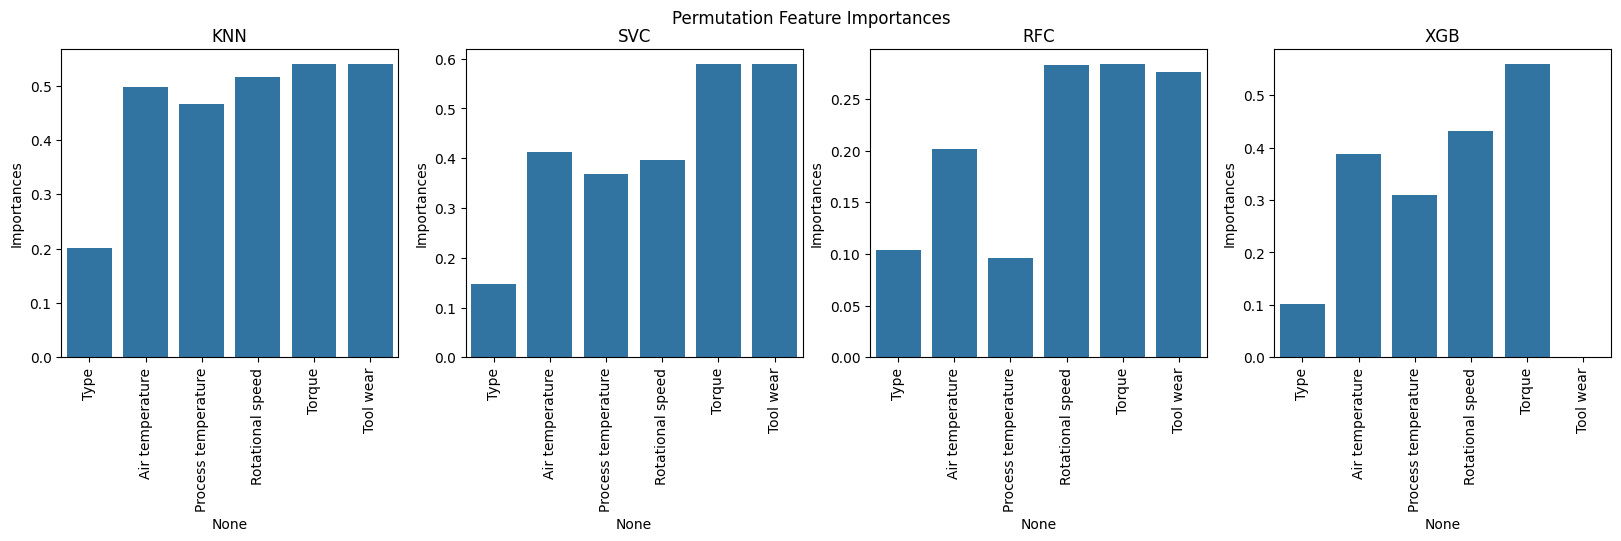

In [ ]:
# Feature Importances
f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)
importances = pd.DataFrame()
for clf in fitted_models_binary:
    result = permutation_importance(clf, X_train,y_train['Target'],
                                  scoring=f2_scorer,random_state=0)
    result_mean = pd.Series(data=result.importances_mean, index=X.columns)
    importances = pd.concat(objs=[importances,result_mean],axis=1)
importances.columns = clf_str

# Barplot of Feature Importances
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Permutation Feature Importances')
for j, name in enumerate(importances.columns):
    sns.barplot(ax=axs[j], x=importances.index, y=importances[name].values)
    axs[j].tick_params('x',labelrotation=90)
    axs[j].set_ylabel('Importances')
    axs[j].title.set_text(str(name))
plt.show()

**Observations:**

1. Type is the feature with the lowest significance, in accordance with what was observed during the exploratory analysis. However, its importance remains strictly positive in each of the cases considered and therefore removing it completely would have led to a decline in prediction performance.

2. Unlike Logistic Regression, the models tested place great emphasis on Tool wear as well as Torque and Rotational Speed.

# **Insights/ Conclusion:**

1. We decided to predict whether a machine will fail or not and predict the type of failure that will occur.
2. Before developing the models we did data preprocessing to ensure the validity of the assumptions of applicability of the models and ensure the best performances. Briefly, in preprocessing phase we have deleted some ambiguous samples, we applied a label encoding to the categorical columns and then we performed the scaling of the columns with StandardScaler.

3. We also noticed the presence of some data points which at first we referred as outliers but later turned out to be part of the natural variance of the data and played an important role in the classification task.

4. Then we ran PCA and found that most of the variance is explained by the first three components, that can be represented as the following features: combination of the two Temperatures, Machine Power (product of Rotational Speed and Torque) and Tool Wear. In according to this, we found that these are the features that contribute the most in the predictions when apply the models. Contrary to logical predictions, we demonstrated that the machine’s type does not affect the presence of failure.

5. At the end, we can conclude that chosen models perform very well. For both tasks the best model is XGBoost and the worst is KNN; however the response time of KNN is instant while XGBoost takes more time and this further increase when we proceed with the multi-class classification task. The choice of the model depends on the needs of the company: for faster application one can use KNN while if one cares more about accuracy one can use XGBoost.